In [1]:
import xarray as xr

In [2]:
fp_root = "/dmidata/projects/cloudphysics/collabs/jakub-lewandowski/july.zarr"

In [3]:
ds = xr.open_zarr(fp_root)
ds

<xarray.Dataset> Size: 14GB
Dimensions:      (time: 4464, y: 900, x: 900)
Coordinates:
  * time         (time) datetime64[ns] 36kB 2021-07-01 ... 2021-07-31T23:50:00
  * x            (x) float64 7kB -4.5e+05 -4.49e+05 ... 4.48e+05 4.49e+05
  * y            (y) float64 7kB 4.49e+05 4.48e+05 ... -4.49e+05 -4.5e+05
Data variables:
    cmax         (time, y, x) float32 14GB dask.array<chunksize=(144, 900, 900), meta=np.ndarray>
    spatial_ref  int64 8B ...

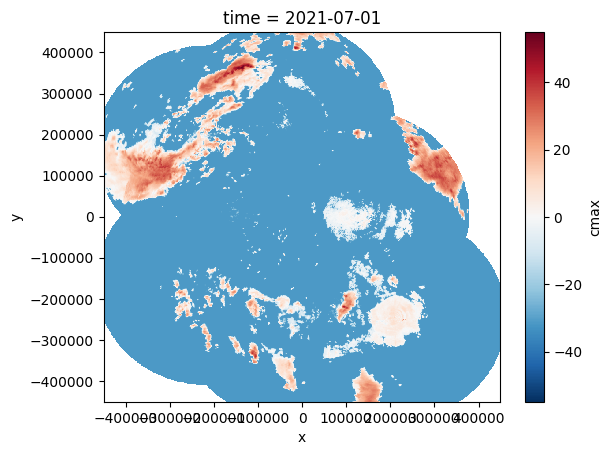

In [4]:
ds.isel(time=0).cmax.plot()

In [5]:
from xarray.core.indexes import isel_indexes
from typing import Literal
    
def construct_consecutive_pairs(ds, var_name, dim, n=1, label: Literal["upper", "lower"] = "upper"):
    """
    Construct a new dataset with consecutive pairs of values from the original dataset
    for a given variable `var_name` along a given dimension `dim`, with spacing `n`.
    
    This code was inspired by `xarray.Dataset.diff`
    
    Parameters
    ----------
    ds : xarray.Dataset
        The original dataset.
    var_name : str
        The name of the variable for which the consecutive pairs should be constructed.
    dim : str
        The dimension along which the pairs should be constructed.
    n : int, optional
        The spacing between the pairs, by default 1.
    label : Literal["upper", "lower"], optional
        Whether to take the upper or lower values of the coordinate values in `dim`
        for the new dataset, by default "upper".
    
    Returns
    -------
    xarray.Dataset
        The new dataset with the consecutive pairs of values, with variables suffixed
        with `__left` and `__right`, e.g. as `{var_name}__left` and `{var_name}__right`.
    
    """
    self = ds

    # prepare slices
    slice_start = {dim: slice(None, -n)}
    slice_end = {dim: slice(n, None)}

    # prepare new coordinate
    if label == "upper":
        slice_new = slice_end
    elif label == "lower":
        slice_new = slice_start
    else:
        raise ValueError("The 'label' argument has to be either 'upper' or 'lower'")

    indexes, index_vars = isel_indexes(self.xindexes, slice_new)
    variables = {}
    
    for name, var in self.variables.items():
        if name in ds.data_vars and name != var_name:
            continue

        if name in index_vars:
            variables[name] = index_vars[name]
        elif dim in var.dims:
            if name in self.data_vars:
                variables[f"{name}__left"] = var.isel(slice_start)
                variables[f"{name}__right"] = var.isel(slice_end)
        else:
            variables[name] = var
            
    result = self._replace_with_new_dims(variables, indexes=indexes)
    
    return result
    
def apply_function_to_consecutive_pairs(ds, var_name, dim, func, n=1, label="upper"):
    """
    Apply a function to the consecutive pairs of values from the original dataset
    for a given variable `var_name` along a given dimension `dim`, with spacing `n`.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The original dataset.
    var_name : str
        The name of the variable for which the consecutive pairs should be constructed.
    dim : str
        The dimension along which the pairs should be constructed.
    n : int, optional
        The spacing between the pairs, by default 1.
    func : callable, optional
        The function to apply to the consecutive pairs of values, should accept two
        xarray.DataArray objects as input and return a new xarray.DataArray object.
    label : Literal["upper", "lower"], optional
        Whether to take the upper or lower values of the coordinate values in `dim`
        for the new dataset, by default "upper".
    
    Returns
    -------
    xarray.DataArray
        The new data array with the result of applying the function to the consecutive pairs of values.
    
    """
    ds2 = construct_consecutive_pairs(ds=ds, var_name=var_name, dim=dim, n=n)

    def _unwrapping_func(ds):
        da_left = ds[f"{var_name}__left"]
        da_right = ds[f"{var_name}__right"]

        return func(da_left=da_left, da_right=da_right)

    return xr.map_blocks(_unwrapping_func, ds2.chunk({dim: 1}))

In [6]:
def example_func(da_left, da_right):
    print(f"{da_left.shape=}, {da_left.dims=}, {da_right.shape=}, {da_right.dims=}")
    return (da_left - da_right).mean(dim=("x", "y"))
    
# using a subset of the data for testing so that we don't print too much to screen
ds_subset = ds.isel(time=slice(0, 30))
da = apply_function_to_consecutive_pairs(ds=ds_subset, var_name="cmax", func=example_func, dim="time", n=1, label="upper")

# no computation has been done yet
da

da_left.shape=(0, 0, 0), da_left.dims=('time', 'y', 'x'), da_right.shape=(0, 0, 0), da_right.dims=('time', 'y', 'x')


<xarray.DataArray (time: 29)> Size: 116B
dask.array<<this-array>-_unwrapping_func, shape=(29,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 232B 2021-07-01T00:10:00 ... 2021-07-01T04...

In [7]:
# using "single-threaded" scheduler to ease debugging, you could for example use dask.Client to use a distributed scheduler
# instead for parallel computation
da.load(scheduler="single-threaded")

da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')
da_left.shape=(1, 900, 900), da_left.dims=('time', 'y', 'x'), da_right.shape=(1, 900, 900), da_right.dims=('time', 'y', 'x')


<xarray.DataArray (time: 29)> Size: 116B
array([ 0.26607582,  0.17949693,  0.13714507,  0.04996817,  0.30431038,
        0.32705614,  0.2510078 ,  0.20713906,  0.24196544,  0.28384084,
        0.09473528,  0.01526913, -0.01972181, -0.15148096, -0.14133069,
       -0.38053215, -0.24149089, -0.18577337, -0.0866795 , -0.17760238,
       -0.10443339, -0.07522891, -0.14694005, -0.14995524, -0.10536625,
       -0.05897347, -0.01086765,  0.15931015,  0.14673102], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 232B 2021-07-01T00:10:00 ... 2021-07-01T04...